In [1]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix, precision_score, f1_score, recall_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

# 0. Creating model to split-fit-evaluate

In [7]:
train_performance_tally = pd.DataFrame()
test_performance_tally = pd.DataFrame()
valid_performance_tally = pd.DataFrame()

In [2]:
logistic = LogisticRegression(max_iter = 1000, solver = 'liblinear', class_weight = 'balanced')

In [3]:
def split_fit_evaluate(model, X, y, X_test, y_test, name):
    scores = []
    #split
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.1, random_state = 42)
    
    #fit
    model.fit(X_train, y_train)

    # Plot side by side
    Xy_collection = [[X_train, y_train, "Training"],
                     [X_valid, y_valid, "Validation"],
                     [X_test, y_test, "Test"]]
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    for i, Xy_true in enumerate(Xy_collection):
        #making predictions
        continuous_preds = model.predict_proba(Xy_true[0])[:, 1]#predicting probability instead of 0 and 1
        discrete_preds = model.predict(Xy_true[0])
        
        #Precision, recall and f1_score
        precision = round(precision_score(Xy_true[1], discrete_preds), 2)
        recall = round(recall_score(Xy_true[1], discrete_preds), 2)
        f1 = round(f1_score(Xy_true[1], discrete_preds), 2)
        temp = pd.Series(data = [precision, recall, f1], index = ["precision", "recall", "F-1"],
                        name = name)
        scores.append(temp)

        #Printing ROC-AUC and classification report
        print(f"\n\nFor {Xy_true[2]}: ") 
        print(f"ROC-AUC Score: {roc_auc_score(Xy_true[1], continuous_preds)}") 
        print(classification_report(Xy_true[1], discrete_preds))

        #Confusion Matrix
        cm = confusion_matrix(Xy_true[1], discrete_preds)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[i])
        axes[i].set_title(f'Predictions on {Xy_true[2]} set')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('True')
        
    plt.show()
    return scores


# 1. Performance on OG dataset

In [4]:
train_data = pd.read_csv("data//maintrain.csv")
X_OG_train = train_data.drop(['HeartDiseaseorAttack'], axis = 1)
y_OG_train = train_data['HeartDiseaseorAttack']

test_data = pd.read_csv("data//maintest.csv")
X_OG_test = test_data.drop(['HeartDiseaseorAttack'], axis = 1)
y_OG_test = test_data['HeartDiseaseorAttack']



For Training: 
ROC-AUC Score: 0.8084921023309517
              precision    recall  f1-score   support

           0       0.96      0.70      0.81    129244
           1       0.26      0.76      0.39     18099

    accuracy                           0.71    147343
   macro avg       0.61      0.73      0.60    147343
weighted avg       0.87      0.71      0.76    147343



For Validation: 
ROC-AUC Score: 0.8096270882058407
              precision    recall  f1-score   support

           0       0.95      0.71      0.82     14331
           1       0.27      0.76      0.40      2041

    accuracy                           0.72     16372
   macro avg       0.61      0.74      0.61     16372
weighted avg       0.87      0.72      0.76     16372



For Test: 
ROC-AUC Score: 0.8121035643602752
              precision    recall  f1-score   support

           0       0.96      0.70      0.81     15886
           1       0.28      0.78      0.41      2305

    accuracy                   

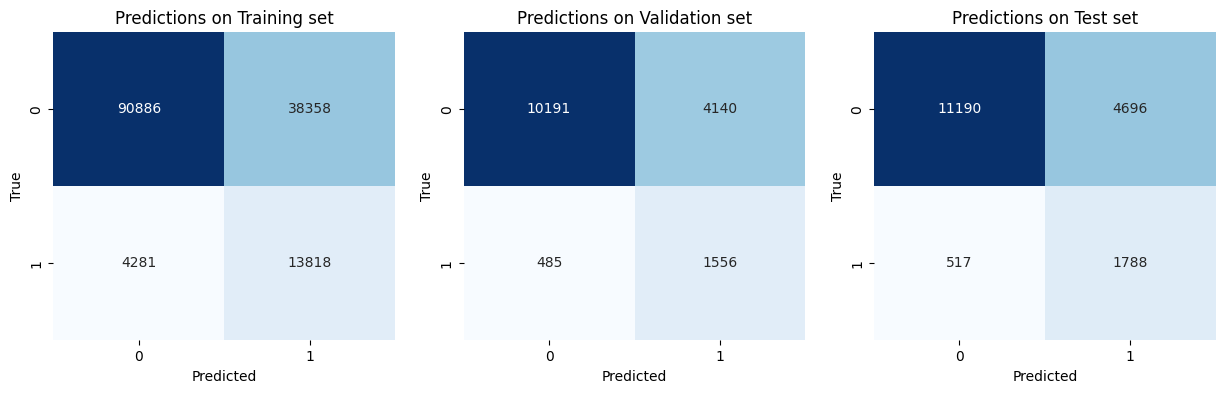

Wall time: 2.94 s


In [5]:
%%time
OG = split_fit_evaluate(logistic, X_OG_train, y_OG_train, X_OG_test, y_OG_test, "OG")

In [8]:
train_performance_tally = pd.concat([train_performance_tally, OG[0]], axis = 1)
valid_performance_tally = pd.concat([valid_performance_tally, OG[1]], axis = 1)
test_performance_tally = pd.concat([test_performance_tally, OG[2]], axis = 1)

# 2. Performance on Reduced Dataset

In [9]:
train_data = pd.read_csv("data//reduced_train.csv")
X_nonbin_train = train_data.drop(['HeartDiseaseorAttack'], axis = 1)
y_nonbin_train = train_data['HeartDiseaseorAttack']

test_data = pd.read_csv("data//reduced_test.csv")
X_nonbin_test = test_data.drop(['HeartDiseaseorAttack'], axis = 1)
y_nonbin_test = test_data['HeartDiseaseorAttack']



For Training: 
ROC-AUC Score: 0.8071764074785301
              precision    recall  f1-score   support

           0       0.95      0.71      0.81    129244
           1       0.26      0.76      0.39     18099

    accuracy                           0.71    147343
   macro avg       0.61      0.73      0.60    147343
weighted avg       0.87      0.71      0.76    147343



For Validation: 
ROC-AUC Score: 0.8078247882678348
              precision    recall  f1-score   support

           0       0.95      0.71      0.82     14331
           1       0.27      0.76      0.40      2041

    accuracy                           0.72     16372
   macro avg       0.61      0.73      0.61     16372
weighted avg       0.87      0.72      0.76     16372



For Test: 
ROC-AUC Score: 0.8104699208541989
              precision    recall  f1-score   support

           0       0.96      0.71      0.81     15886
           1       0.28      0.77      0.41      2305

    accuracy                   

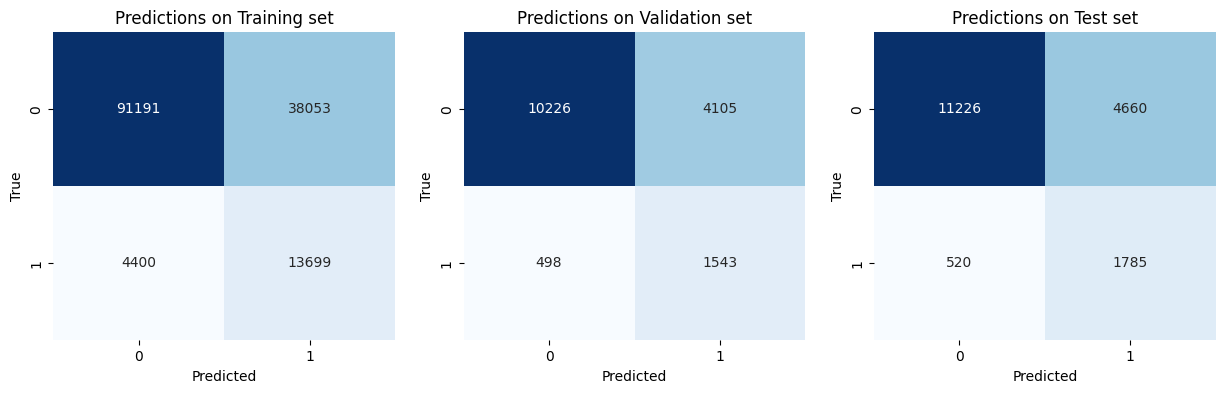

Wall time: 2.33 s


In [10]:
%%time
reducedOG = split_fit_evaluate(logistic, X_nonbin_train, y_nonbin_train, X_nonbin_test, y_nonbin_test,
                   "reducedOG")

In [11]:
train_performance_tally = pd.concat([train_performance_tally, reducedOG[0]], axis = 1)
valid_performance_tally = pd.concat([valid_performance_tally, reducedOG[1]], axis = 1)
test_performance_tally = pd.concat([test_performance_tally, reducedOG[2]], axis = 1)

# 3.Undersampling

## 3.1. Manual Undersampling

In [12]:
#Checking distribution of y
y_OG_train.value_counts()

HeartDiseaseorAttack
0    143575
1     20140
Name: count, dtype: int64

In [13]:
#Picking random 20140 values of y = 0 and discarding the rest
df_OG_train = pd.concat([X_OG_train, y_OG_train], axis = 1)

#Creating the smaller balanced dataset
df_for_y1 = df_OG_train.loc[df_OG_train.HeartDiseaseorAttack == 1]
df_for_y0 = df_OG_train.loc[df_OG_train.HeartDiseaseorAttack == 0][:20140]

df_us = pd.concat([df_for_y1, df_for_y0], axis = 0)
df_us = df_us.sample(frac = 1, random_state = 42)#Shuffle the data around

In [14]:
df_us.head(5)

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Age,HeartDiseaseorAttack
14047,1,1,1,30,0,0,0,1,1,1,1,1,0,2,0,0,0,7,0
8556,0,0,1,31,1,0,0,1,0,1,0,0,0,2,0,0,0,10,0
72432,0,0,1,25,1,0,0,1,1,0,0,1,0,4,0,0,0,12,1
99803,1,0,1,33,0,0,0,1,1,1,0,1,0,4,0,0,1,13,1
41627,0,1,1,26,1,0,2,0,1,0,0,1,0,3,0,0,0,12,1


In [15]:
#Creating X_US and y_US
X_us = df_us.drop('HeartDiseaseorAttack', axis = 1)
y_us = df_us['HeartDiseaseorAttack']

<Axes: >

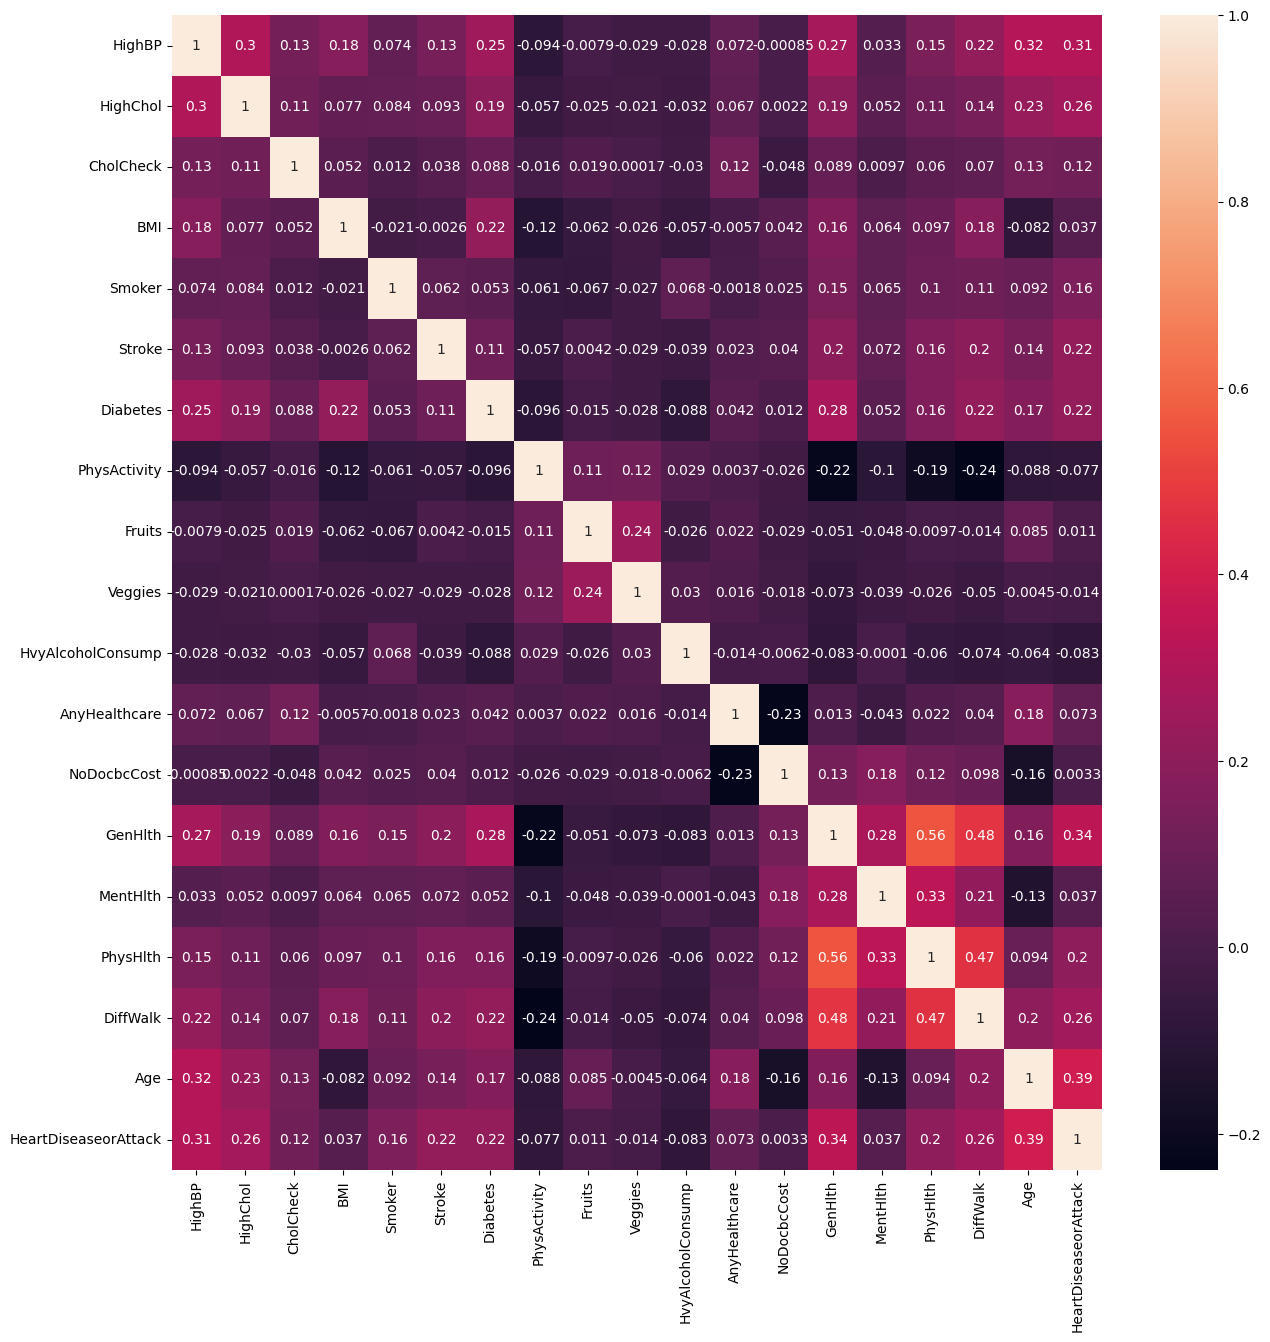

In [16]:
#looking at correlation matrix now
plt.figure(figsize = (15, 15))
sns.heatmap(df_us.corr(), annot = True)
#Suprisingly none of the column pairs are highly or lowly correlated



For Training: 
ROC-AUC Score: 0.8119485625769287
              precision    recall  f1-score   support

           0       0.75      0.70      0.73     18194
           1       0.72      0.77      0.74     18058

    accuracy                           0.73     36252
   macro avg       0.74      0.74      0.73     36252
weighted avg       0.74      0.73      0.73     36252



For Validation: 
ROC-AUC Score: 0.8065568130098637
              precision    recall  f1-score   support

           0       0.73      0.71      0.72      1946
           1       0.74      0.75      0.74      2082

    accuracy                           0.73      4028
   macro avg       0.73      0.73      0.73      4028
weighted avg       0.73      0.73      0.73      4028



For Test: 
ROC-AUC Score: 0.8120926405410787
              precision    recall  f1-score   support

           0       0.96      0.70      0.81     15886
           1       0.27      0.78      0.41      2305

    accuracy                   

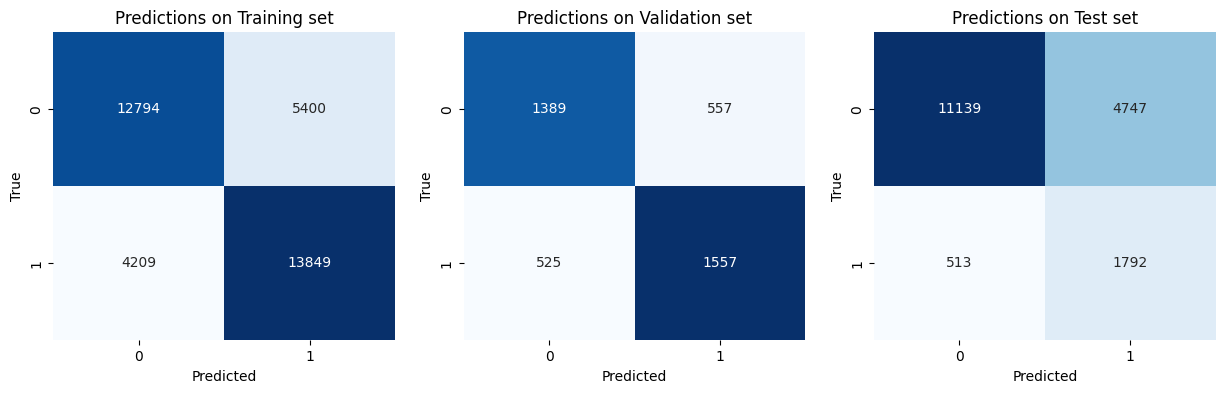

Wall time: 1.08 s


In [17]:
%%time
MUS = split_fit_evaluate(logistic, X_us, y_us, X_OG_test, y_OG_test, "MUS")

In [18]:
train_performance_tally = pd.concat([train_performance_tally, MUS[0]], axis = 1)
valid_performance_tally = pd.concat([valid_performance_tally, MUS[1]], axis = 1)
test_performance_tally = pd.concat([test_performance_tally, MUS[2]], axis = 1)

## 3.2 Using RandomUnderSampler

In [19]:
undersampler = RandomUnderSampler(sampling_strategy = 1)
X_under, y_under = undersampler.fit_resample(X_OG_train, y_OG_train)
print(Counter(y_under))

Counter({0: 20140, 1: 20140})


In [20]:
logistic = LogisticRegression(max_iter = 1000, solver = 'liblinear', class_weight = 'balanced')



For Training: 
ROC-AUC Score: 0.8094717586613918
              precision    recall  f1-score   support

           0       0.75      0.70      0.73     18164
           1       0.72      0.77      0.74     18088

    accuracy                           0.73     36252
   macro avg       0.73      0.73      0.73     36252
weighted avg       0.73      0.73      0.73     36252



For Validation: 
ROC-AUC Score: 0.804959341533095
              precision    recall  f1-score   support

           0       0.73      0.70      0.72      1976
           1       0.72      0.75      0.74      2052

    accuracy                           0.73      4028
   macro avg       0.73      0.73      0.73      4028
weighted avg       0.73      0.73      0.73      4028



For Test: 
ROC-AUC Score: 0.8121525030702759
              precision    recall  f1-score   support

           0       0.96      0.70      0.81     15886
           1       0.27      0.78      0.41      2305

    accuracy                    

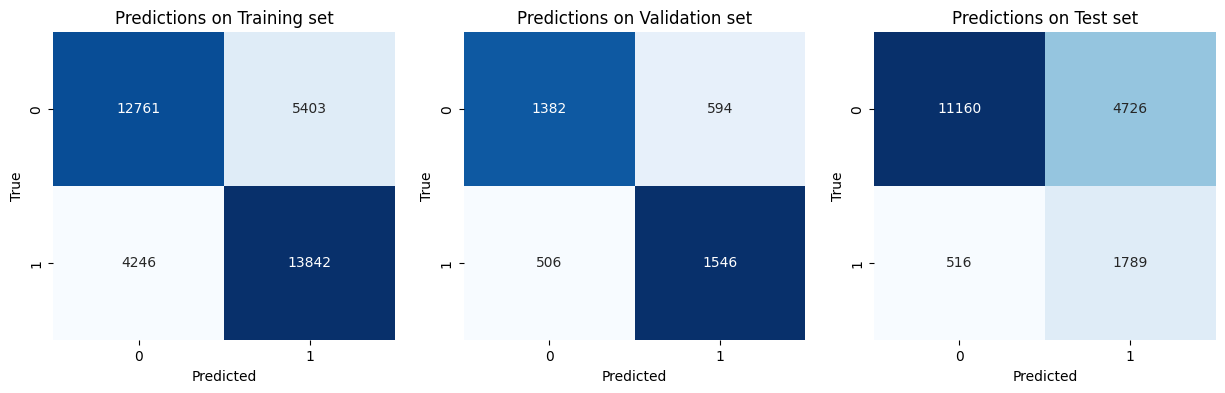

Wall time: 985 ms


In [21]:
%%time
RUS = split_fit_evaluate(logistic, X_under, y_under, X_OG_test, y_OG_test, "RUS")

In [22]:
train_performance_tally = pd.concat([train_performance_tally, RUS[0]], axis = 1)
valid_performance_tally = pd.concat([valid_performance_tally, RUS[1]], axis = 1)
test_performance_tally = pd.concat([test_performance_tally, RUS[2]], axis = 1)

# 4. Oversampling

## 4.1 Oversampling with SMOTE

In [23]:
oversampler = SMOTE(sampling_strategy = 0.4)
X_SMOTE, y_SMOTE = oversampler.fit_resample(X_OG_train, y_OG_train)



For Training: 
ROC-AUC Score: 0.7828319100361454
              precision    recall  f1-score   support

           0       0.87      0.67      0.76    129253
           1       0.48      0.76      0.59     51651

    accuracy                           0.70    180904
   macro avg       0.68      0.72      0.67    180904
weighted avg       0.76      0.70      0.71    180904



For Validation: 
ROC-AUC Score: 0.7814765256587427
              precision    recall  f1-score   support

           0       0.87      0.68      0.76     14322
           1       0.49      0.75      0.59      5779

    accuracy                           0.70     20101
   macro avg       0.68      0.72      0.68     20101
weighted avg       0.76      0.70      0.71     20101



For Test: 
ROC-AUC Score: 0.7888433669067813
              precision    recall  f1-score   support

           0       0.95      0.67      0.79     15886
           1       0.25      0.76      0.38      2305

    accuracy                   

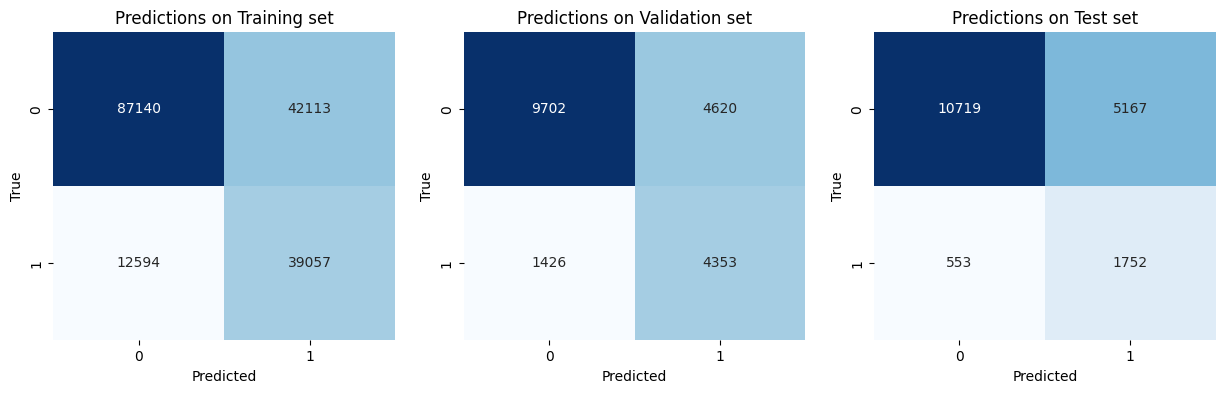

Wall time: 3.59 s


In [24]:
%%time
smote = split_fit_evaluate(logistic, X_SMOTE, y_SMOTE, X_OG_test, y_OG_test, "SMOTE")

In [25]:
train_performance_tally = pd.concat([train_performance_tally, smote[0]], axis = 1)
valid_performance_tally = pd.concat([valid_performance_tally, smote[1]], axis = 1)
test_performance_tally = pd.concat([test_performance_tally, smote[2]], axis = 1)

# 5. Oversampling + Undersampling

## 5.1. SMOTEENN

In [26]:
%%time
sampler = SMOTEENN(sampling_strategy = 0.5, n_jobs = -1)
X_SMOTEENN, y_SMOTEENN = sampler.fit_resample(X_nonbin_test, y_nonbin_test)

C:\Users\rajni\anaconda3\lib\site-packages\imblearn\over_sampling\_smote\base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Wall time: 673 ms




For Training: 
ROC-AUC Score: 0.8852279457390354
              precision    recall  f1-score   support

           0       0.92      0.79      0.85      9282
           1       0.61      0.82      0.70      3660

    accuracy                           0.80     12942
   macro avg       0.76      0.80      0.77     12942
weighted avg       0.83      0.80      0.81     12942



For Validation: 
ROC-AUC Score: 0.8869457297088876
              precision    recall  f1-score   support

           0       0.92      0.80      0.86      1040
           1       0.61      0.81      0.70       399

    accuracy                           0.80      1439
   macro avg       0.76      0.81      0.78      1439
weighted avg       0.83      0.80      0.81      1439



For Test: 
ROC-AUC Score: 0.7808504838410424
              precision    recall  f1-score   support

           0       0.95      0.64      0.77    143575
           1       0.23      0.78      0.36     20140

    accuracy                   

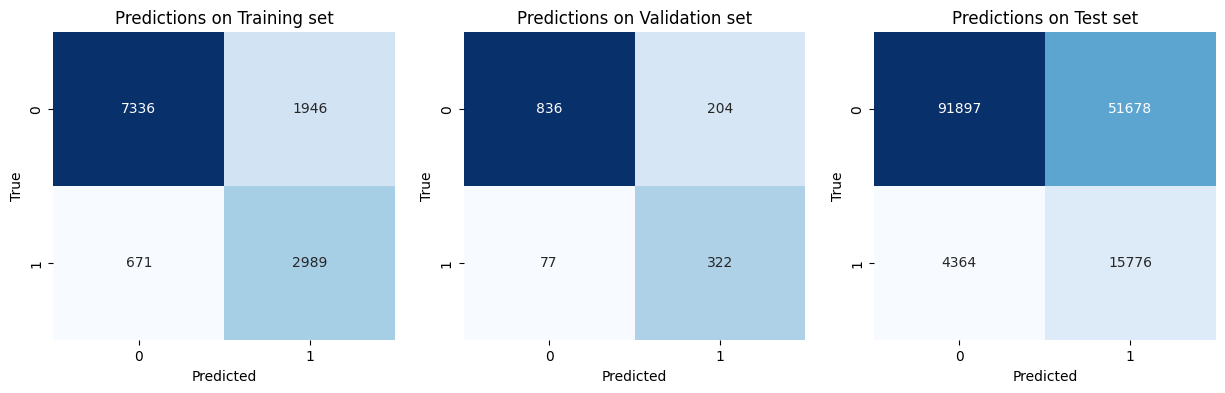

Wall time: 1.37 s


In [27]:
%%time
smoteenn = split_fit_evaluate(logistic, X_SMOTEENN, y_SMOTEENN, X_nonbin_train, y_nonbin_train, "SMOTEENN")

In [28]:
train_performance_tally = pd.concat([train_performance_tally, smoteenn[0]], axis = 1)
valid_performance_tally = pd.concat([valid_performance_tally, smoteenn[1]], axis = 1)
test_performance_tally = pd.concat([test_performance_tally, smoteenn[2]], axis = 1)

In [29]:
print(train_performance_tally)
print("\n")
print(valid_performance_tally)
print("\n")
print(test_performance_tally)

             OG  reducedOG   MUS   RUS  SMOTE  SMOTEENN
precision  0.26       0.26  0.72  0.72   0.48      0.61
recall     0.76       0.76  0.77  0.77   0.76      0.82
F-1        0.39       0.39  0.74  0.74   0.59      0.70


             OG  reducedOG   MUS   RUS  SMOTE  SMOTEENN
precision  0.27       0.27  0.74  0.72   0.49      0.61
recall     0.76       0.76  0.75  0.75   0.75      0.81
F-1        0.40       0.40  0.74  0.74   0.59      0.70


             OG  reducedOG   MUS   RUS  SMOTE  SMOTEENN
precision  0.28       0.28  0.27  0.27   0.25      0.23
recall     0.78       0.77  0.78  0.78   0.76      0.78
F-1        0.41       0.41  0.41  0.41   0.38      0.36


In [30]:
train_performance_tally.T

,precision,recall,F-1
OG,0.26,0.76,0.39
reducedOG,0.26,0.76,0.39
MUS,0.72,0.77,0.74
RUS,0.72,0.77,0.74
SMOTE,0.48,0.76,0.59
SMOTEENN,0.61,0.82,0.70


In [31]:
train = pd.Series(train_performance_tally.T.iloc[:, 2], name = 'Train')
valid = pd.Series(valid_performance_tally.T.iloc[:, 2], name = 'Valid')
test = pd.Series(test_performance_tally.T.iloc[:, 2], name = 'Test')

f1_tally = pd.concat([train, valid, test], axis = 1)
print("F1 Score comparison")
f1_tally

F1 Score comparison


,Train,Valid,Test
OG,0.39,0.40,0.41
reducedOG,0.39,0.40,0.41
MUS,0.74,0.74,0.41
RUS,0.74,0.74,0.41
SMOTE,0.59,0.59,0.38
SMOTEENN,0.70,0.70,0.36


In [32]:
train = pd.Series(train_performance_tally.T.iloc[:, 1], name = 'Train')
valid = pd.Series(valid_performance_tally.T.iloc[:, 1], name = 'Valid')
test = pd.Series(test_performance_tally.T.iloc[:, 1], name = 'Test')

recall_tally = pd.concat([train, valid, test], axis = 1)
print("recall Score comparison")
recall_tally

recall Score comparison


,Train,Valid,Test
OG,0.76,0.76,0.78
reducedOG,0.76,0.76,0.77
MUS,0.77,0.75,0.78
RUS,0.77,0.75,0.78
SMOTE,0.76,0.75,0.76
SMOTEENN,0.82,0.81,0.78


In [33]:
train = pd.Series(train_performance_tally.T.iloc[:, 0], name = 'Train')
valid = pd.Series(valid_performance_tally.T.iloc[:, 0], name = 'Valid')
test = pd.Series(test_performance_tally.T.iloc[:, 0], name = 'Test')

precision_tally = pd.concat([train, valid, test], axis = 1)
print("precision Score comparison")
precision_tally

precision Score comparison


,Train,Valid,Test
OG,0.26,0.27,0.28
reducedOG,0.26,0.27,0.28
MUS,0.72,0.74,0.27
RUS,0.72,0.72,0.27
SMOTE,0.48,0.49,0.25
SMOTEENN,0.61,0.61,0.23
